In [103]:
%reset -f

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from math import sqrt
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima


%matplotlib inline

In [105]:
advanced_df = pd.read_csv("dataset_mood_smartphone (1).csv", index_col=0)

In [106]:
advanced_df.head()

,id,time,variable,value
1,AS14.01,2014-02-26 13:00:00.000,mood,6.0
2,AS14.01,2014-02-26 15:00:00.000,mood,6.0
3,AS14.01,2014-02-26 18:00:00.000,mood,6.0
4,AS14.01,2014-02-26 21:00:00.000,mood,7.0
5,AS14.01,2014-02-27 09:00:00.000,mood,6.0


## Define functions

In [107]:
# Check the shape of a dataframe, along with NaN values
def check_df(df):
    print(df.shape)
    for item in df.columns:
        print(item, ': ', type(df[item]), ', contains NaN:',df[item].isnull().values.any())

# Plot all the variables vs time
def plot_feature(df, variable_name, participant=None):
    ylabel_text = f"{variable_name} value"
    title_text = f"{variable_name} vs time"

    if participant:
        plot = df[(df['variable'] == variable_name) & (df['id'] == participant)]
    else:
        plot = df[(df['variable'] == variable_name)]

    plt.plot(plot['time'], plot['value'], label = variable_name)
    plt.xlabel('time')
    plt.ylabel(ylabel_text)
    plt.title(title_text)
    plt.legend(loc='lower right')
    plt.show()

# Plot histograms of all the variables
def plot_histograms(df, variable_name, participant=None):

    if participant:
        df[(df['variable'] == variable_name) & (df['id'] == participant)].plot(kind='hist', edgecolor='black', legend = variable_name)
    else:
        df[(df['variable'] == variable_name)].plot(kind='hist', edgecolor='black', legend = variable_name)
    plt.xlabel(variable_name)
    plt.legend(loc='lower right')

# Remove outliers >0.75 and <0.25 of all values, excepting mood, call, sms etc
def remove_outliers(df, column_name, multiplier=1.5):
    q1 = df[column_name].quantile(0.25)
    q2 = df[column_name].quantile(0.75)
    iqr = q2 - q1
    lower_bound = q1 - multiplier * iqr
    upper_bound = q2 + multiplier * iqr
    return df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

# Check a dataframe for class balance
def check_class_balance(df, target_column):
    print(df[target_column].value_counts())

def impute_with_group_mean(df):
    mean_value = df['mood'].mean()
    return df['mood'].fillna(mean_value)



## Check for dataframe shape and NaN values

In [108]:
check_df(advanced_df)

(376912, 4)
id :  <class 'pandas.core.series.Series'> , contains NaN: False
time :  <class 'pandas.core.series.Series'> , contains NaN: False
variable :  <class 'pandas.core.series.Series'> , contains NaN: False
value :  <class 'pandas.core.series.Series'> , contains NaN: True


## Checking which variables have NaN values

In [109]:
advanced_df.query('value.isnull()')

,id,time,variable,value
5709,AS14.01,2014-04-02 18:00:00.000,circumplex.arousal,NaN
5731,AS14.01,2014-04-07 15:00:00.000,circumplex.arousal,NaN
5773,AS14.01,2014-04-16 12:00:00.000,circumplex.arousal,NaN
5797,AS14.01,2014-04-21 13:00:00.000,circumplex.arousal,NaN
5836,AS14.01,2014-04-29 09:00:00.000,circumplex.arousal,NaN
...,...,...,...,...
16859,AS14.33,2014-05-16 20:00:00.000,circumplex.valence,NaN
16862,AS14.33,2014-05-17 12:00:00.000,circumplex.valence,NaN
16882,AS14.33,2014-05-21 16:00:00.000,circumplex.valence,NaN
16899,AS14.33,2014-05-24 23:00:00.000,circumplex.valence,NaN


### The only variables that contain NaN values are circumplex.arousal and circumplex.valence. Discussion needs to be made if these values should be removed or be converted to 0s

## Drop rows with NaN values

In [110]:
advanced_df.dropna(inplace=True)
check_df(advanced_df)

(376710, 4)
id :  <class 'pandas.core.series.Series'> , contains NaN: False
time :  <class 'pandas.core.series.Series'> , contains NaN: False
variable :  <class 'pandas.core.series.Series'> , contains NaN: False
value :  <class 'pandas.core.series.Series'> , contains NaN: False


## Sort dataframe by id and time

In [111]:
advanced_df.sort_values(['id', 'time'], inplace=True)

In [112]:
advanced_df.query('variable == "mood" and value == "0"')

,id,time,variable,value


## Plot all features vs time for participant AS14.01

In [113]:
# for name in advanced_df['variable'].unique():
#     plot_histograms(advanced_df, name)

In [114]:
# for name in advanced_df['variable'].unique():
#     plot_feature(advanced_df, name, 'AS14.01')

## Plot variable values to check for distribution for participant AS14.01

In [115]:
# for name in advanced_df['variable'].unique():
#     plot_histograms(advanced_df, name, 'AS14.01')

## Calculate mean and sd for each variable

In [116]:
result = advanced_df.groupby('variable')['value'].agg(['mean', 'std'])

## Remove outliers for all participants

In [117]:
filtered_data = []
exception_list = ['mood', 'sms', 'call', 'circumplex.arousal', 'circumplex.valence', 'activity']

for name in advanced_df['variable'].unique():
    if name in exception_list:
        filtered_data.append(advanced_df[advanced_df['variable'] == name])
        continue
    else:
        group = advanced_df[advanced_df['variable'] == name]
        filtered_group = remove_outliers(group, 'value')
        filtered_data.append(filtered_group)

clean_df = pd.concat(filtered_data)

## Check variable vs time after outliers removed

In [118]:
# for name in clean_df['variable'].unique():
#     plot_feature(clean_df, name, 'AS14.01')

## Check variable distribution for participant AS14.01 with the new data

In [119]:
# for name in advanced_df['variable'].unique():
#     plot_histograms(advanced_df, name   )

In [120]:
# for name in advanced_df['variable'].unique():
#     plot_histograms(advanced_df, name, 'AS14.01')

# Data engineering

## For each variable, calculate the average value if the variable is continuous and the count if the value is categorical, for each day, and distinguish the variable column to different features.

In [121]:
# Convert timestamp to datetime object and extract date
clean_df['time'] = pd.to_datetime(clean_df['time']).dt.date

# List of continuous and categorical variables
continuous_vars = ['mood', 'screen', 'appCat.builtin', 'appCat.communication', 'appCat.entertainment', 'appCat.finance', 'appCat.game', 'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather', 'circumplex.arousal', 'circumplex.valence', 'activity']
categorical_vars = ['call', 'sms']

# Define aggregation functions for continuous and categorical variables
aggregations = {}
for var in continuous_vars:
    aggregations[var] = 'mean'
for var in categorical_vars:
    aggregations[var] = 'count'


In [122]:
# Filter the dataframe for continuous and categorical variables
cont_df = clean_df[clean_df['variable'].isin(continuous_vars)].pivot_table(index=['id', 'time'], columns='variable', values='value').reset_index()
cat_df = clean_df[clean_df['variable'].isin(categorical_vars)].pivot_table(index=['id', 'time'], columns='variable', values='value', aggfunc='count').reset_index()

# Merge the dataframes
result = pd.merge(cont_df, cat_df, on=['id', 'time'], how='outer')

In [123]:
result.sort_values(by='time', inplace = True)

In [124]:
arima_df = result[['time', 'id', 'mood']].copy()


In [125]:
## dropping end NaNs

for i, participant in enumerate(arima_df['id'].unique()):
    dfper = arima_df[arima_df['id']==participant]
    
    for index, row in dfper.iterrows():
        if row.mood > 0:
            break
        else:
            arima_df = arima_df.drop(index)

arima_df.sort_values(by='time', inplace = True, ascending = False)

for i, participant in enumerate(arima_df['id'].unique()):
    dfper = arima_df[arima_df['id']==participant]
    
    for index, row in dfper.iterrows():
        if row.mood > 0:
            break
        else:
            arima_df = arima_df.drop(index)

arima_df.sort_values(by='time', inplace = True, ascending = True)


In [126]:
#arima_df['mood'] = arima_df['mood'].fillna(arima_df['id'].map(arima_df.groupby('id')['mood'].mean()))
#arima_df.groupby('id').apply(impute_with_group_mean).reset_index(drop=True)


In [127]:

missing = arima_df['mood'].isnull()
series = arima_df['mood']
# Split the series into a training set (with non-missing values) and a test set (with missing values)
train_x = series.index[~missing]
train_y = series[~missing]
test_x = series.index[missing]

# Fit a linear regression model to the training data
model = LinearRegression()
model.fit(train_x.values.reshape(-1, 1), train_y)
# Use the model to predict the missing values
imputed_values = model.predict(test_x.values.reshape(-1, 1))
# Return the imputed series
series[missing] = imputed_values
arima_df['mood'] = series

#arima_df['mood'] = arima_df['mood'].fillna(arima_df['id'].map(arima_df.groupby('id')['mood'].transform(impute_regression)))
#arima_df['mood'] = (arima_df.groupby('id')['mood'].transform(impute_regression))
#arima_df.groupby('id')['mood'].transform(impute_regression)


/var/folders/9j/5bfcvwzx4dq156jh1d694vk80000gn/T/ipykernel_2777/35112572.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series[missing] = imputed_values


# ML classifier

In [128]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf

## Section for classic ML models

## Check for class balance

## We need to balance these classes to train the model, if not the model will be biased towards predicting more 0s and 7s

## Upsampling with SMOTE

## Section for ARIMA model. The difference is that ARIMA does not need the rest features, only time and mood.

In [129]:
arima_df['time'] = pd.to_datetime(arima_df['time'])


In [130]:
arima_df.reset_index(drop=True, inplace=True)
arima_df.set_index('time', inplace=True)



In [131]:
results = {'id':[], 'test_data':[], 'predicted_mood':[], 'orders':[],'rmse':[]}
results = pd.DataFrame(results)


In [132]:
def pval(df):
    test = adfuller(df,autolag= 'AIC')
    pvalue = test[1]
    #print('ADF: ',test[0])
    #print('p-value: ',test[1])
    #print('nr lags: ',test[2])
    #print('nr observations for adf regression: ',test[3])
    #print('critical values: ',test[0])
    #for key, val in test[4].items():
    #    print("\t",key, ": ", val)    
    return pvalue

def get_orders(df):
    stepwise_fit = auto_arima(df, trace=False, suppress_warnings=True, disp=0)
    p, d, q = stepwise_fit.order
    return p, d, q

def testtrain(df):
    x = int(df.shape[0]*0.95) 
    train=df.iloc[:x]
    test=df.iloc[x:]
    return train, test

def predict(model):
    start=len(train)
    end=len(train)+len(test)-1
    pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
    return pred

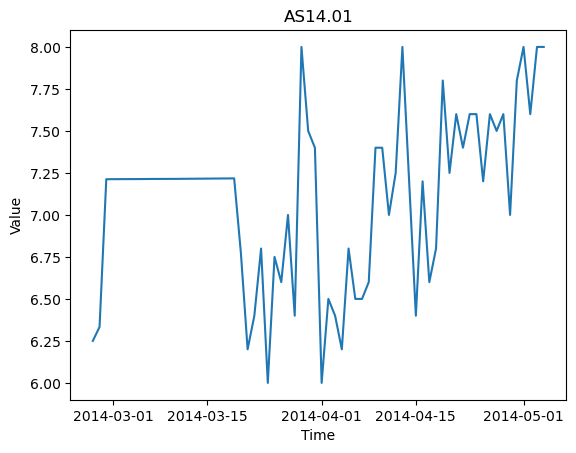

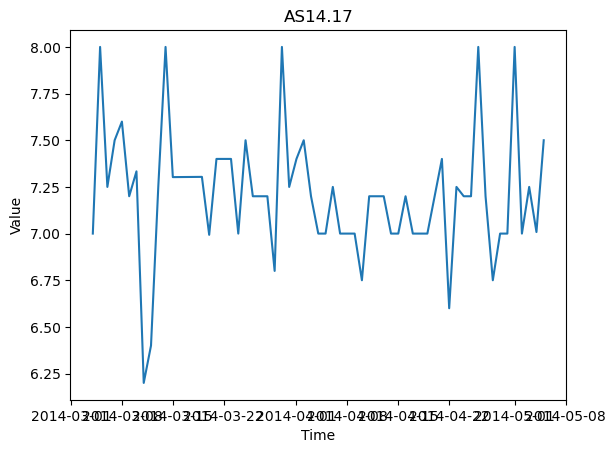

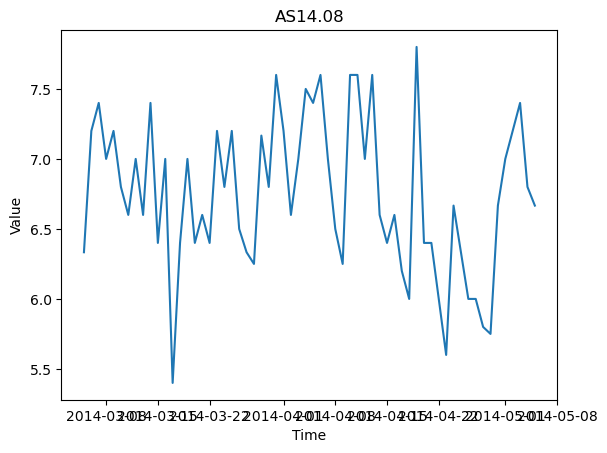

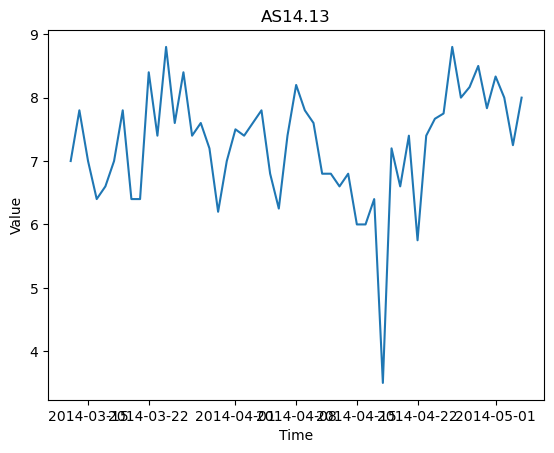

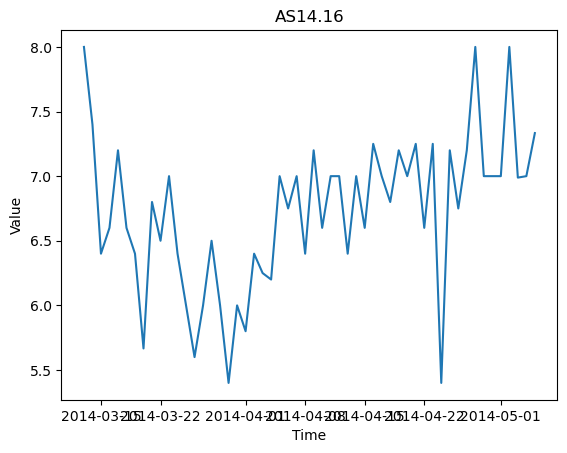

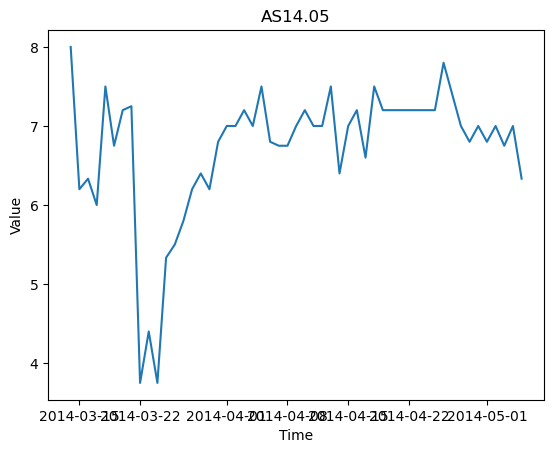

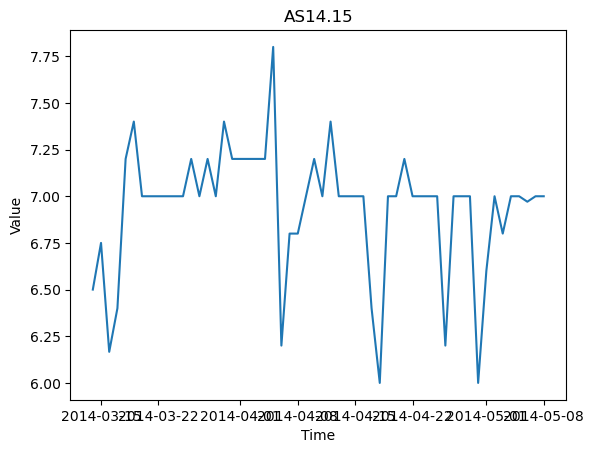

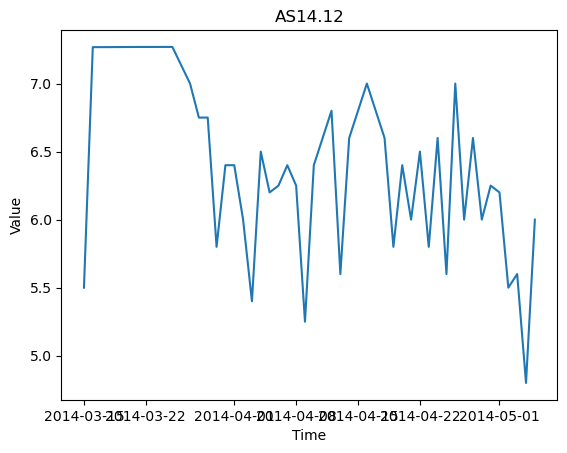

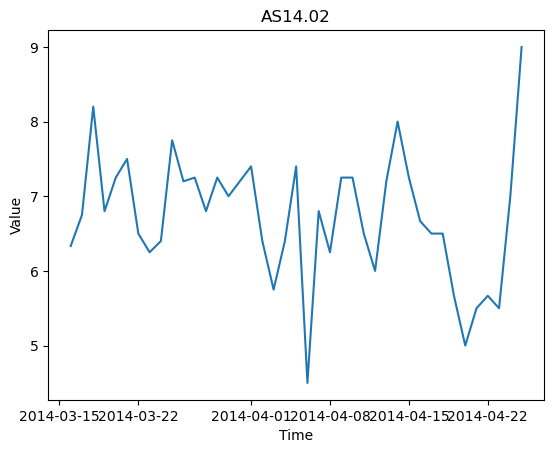

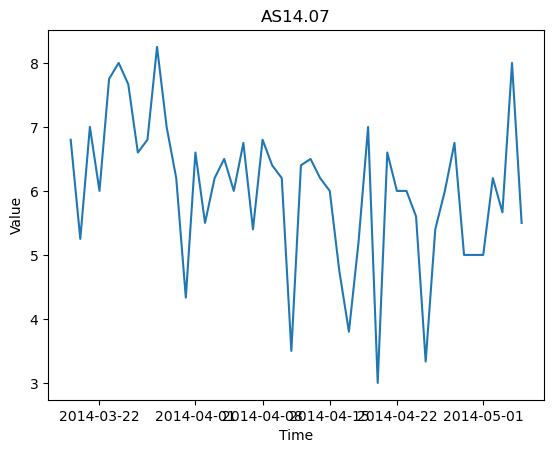

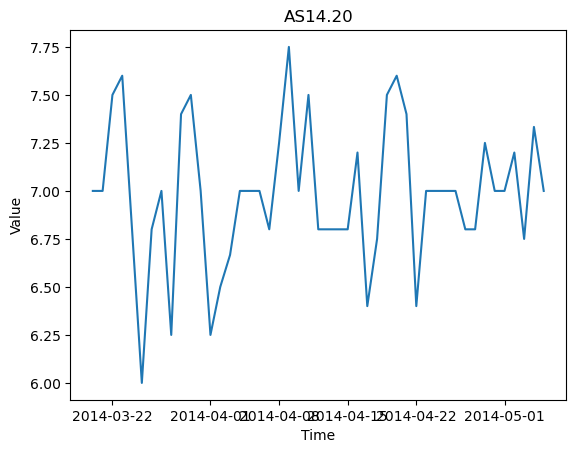

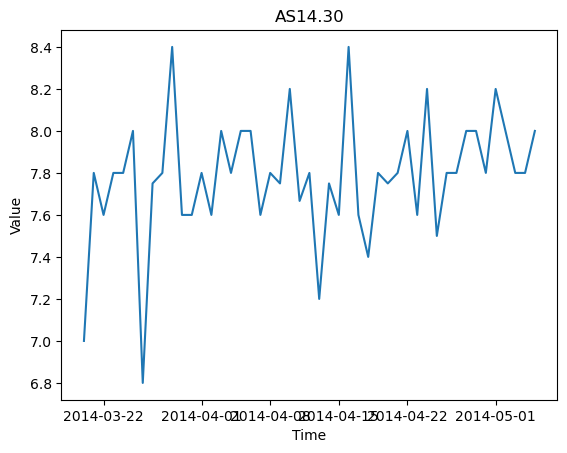

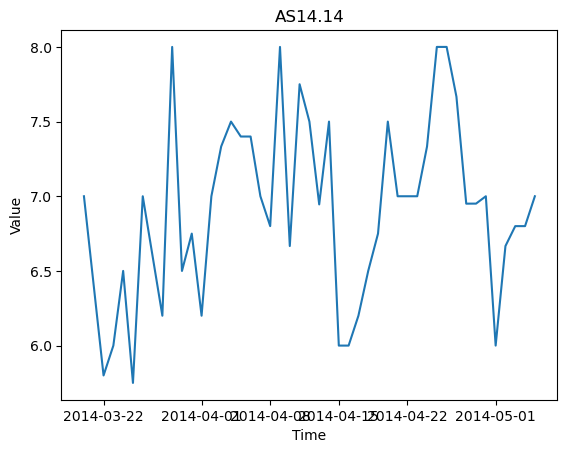

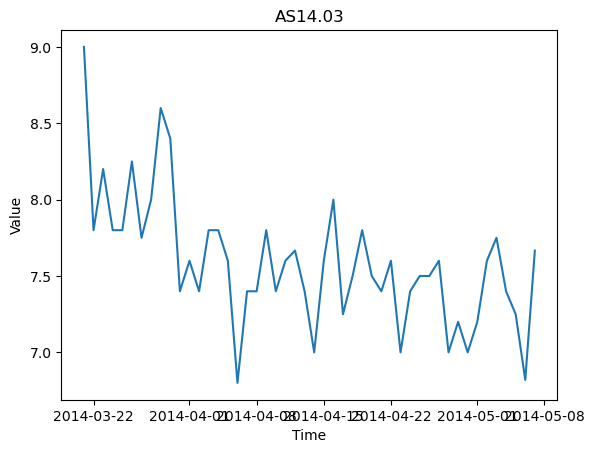

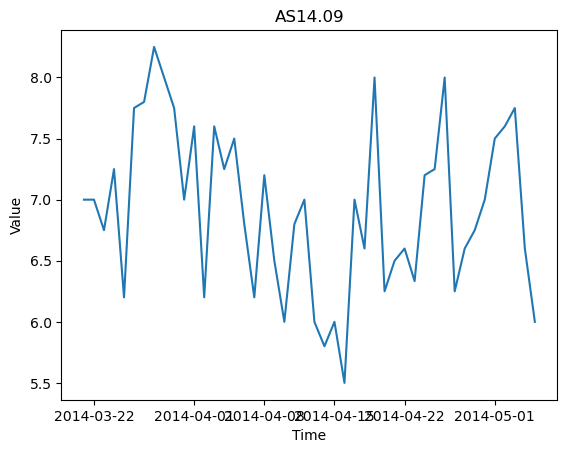

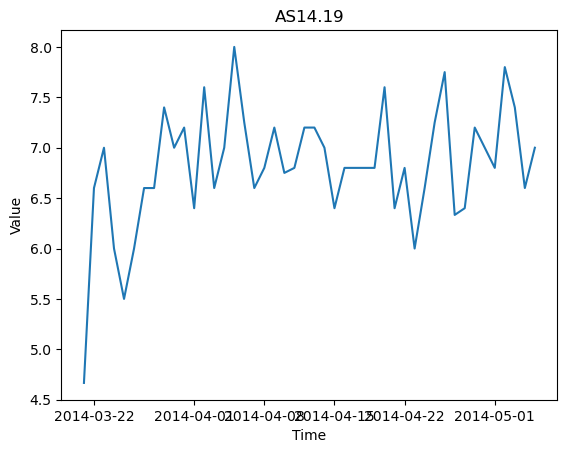

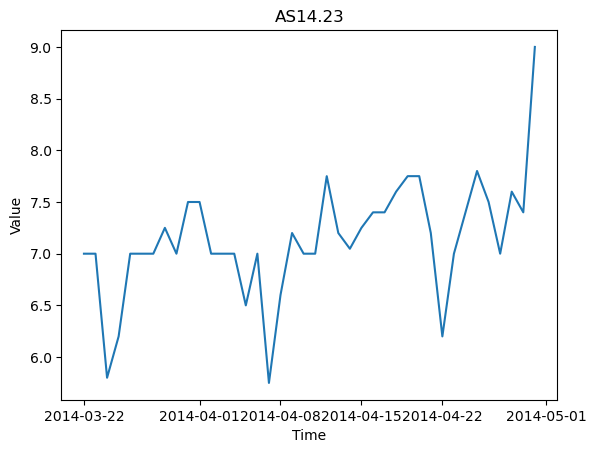

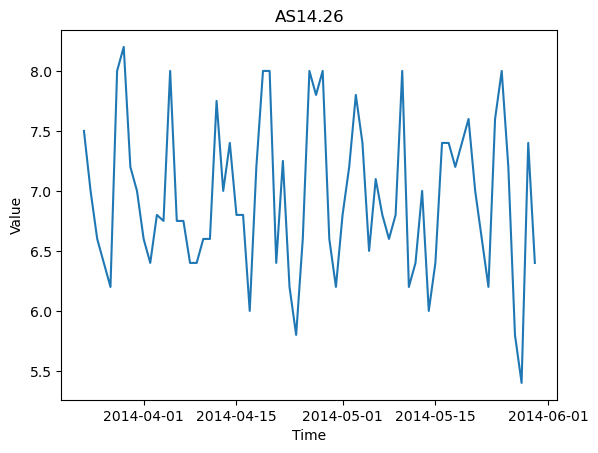

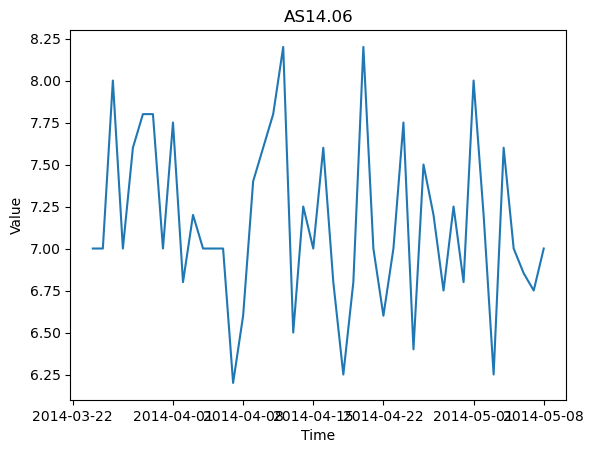

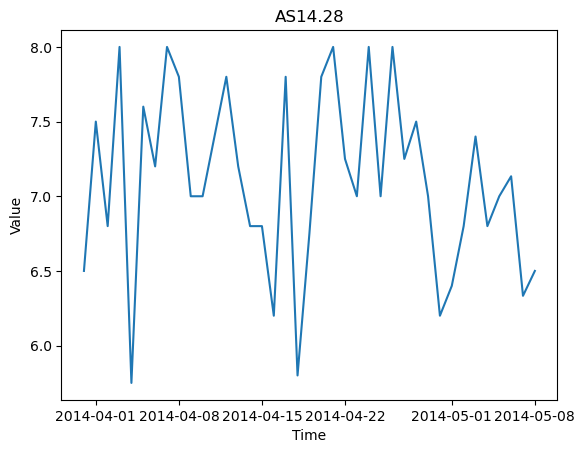

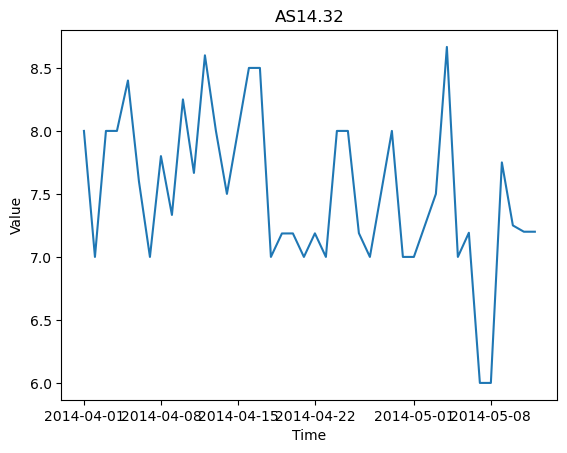

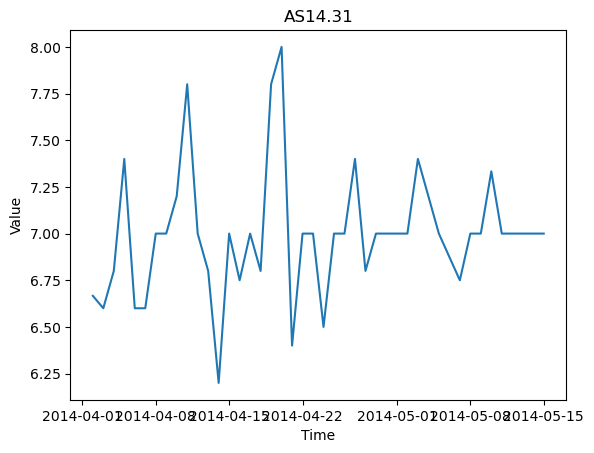

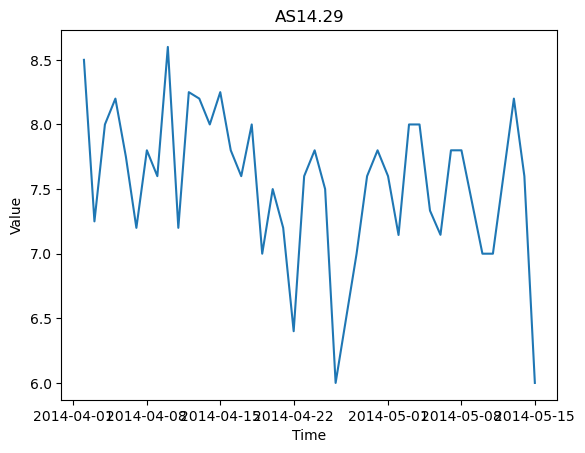

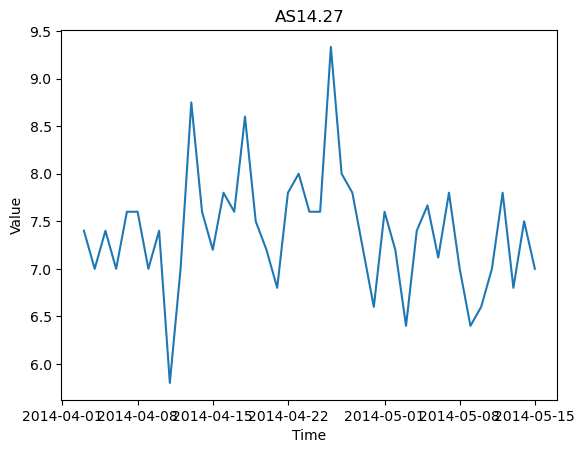

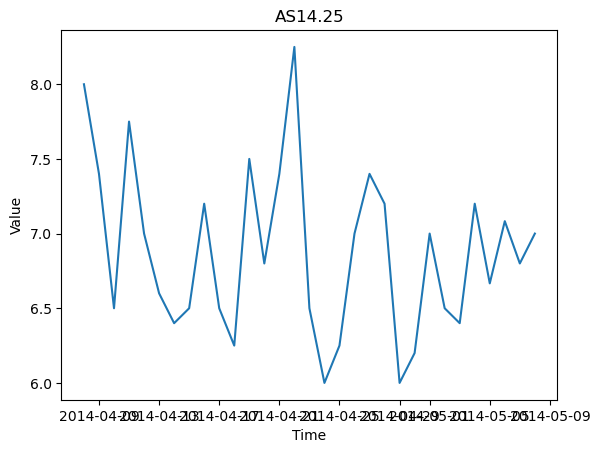

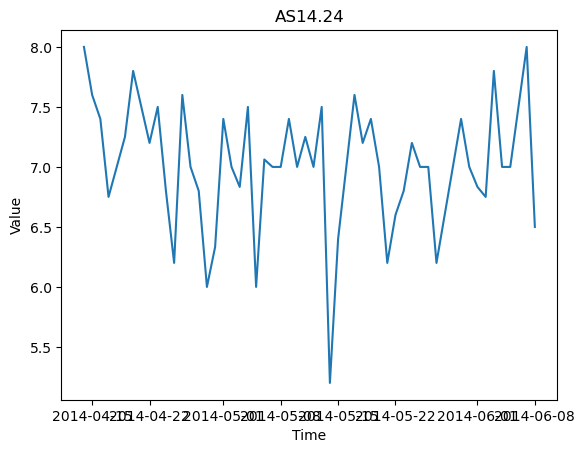

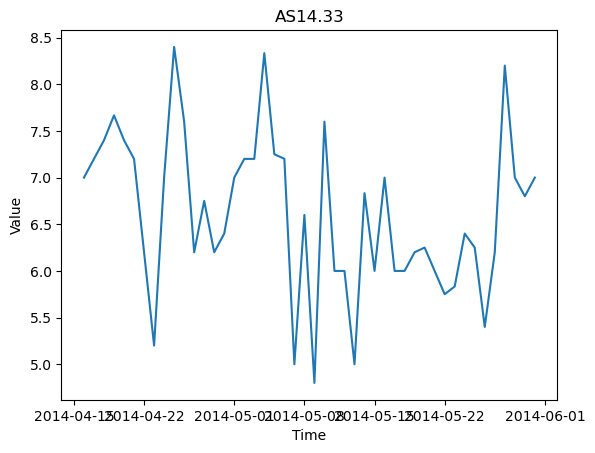

In [133]:
for i, participant in enumerate(arima_df['id'].unique()):
    dfper = arima_df[arima_df['id']==participant].mood

    fig, ax = plt.subplots()
    ax.plot(dfper)

    ax.set_title(participant)
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")

    plt.show()

In [134]:

for i, participant in enumerate(arima_df['id'].unique()):
    
    dfper = arima_df[arima_df['id']==participant].mood
    pvalue = pval(dfper)
    p,d,q= get_orders(dfper)
    train,test = testtrain(dfper)
    orders = [p,d,q]

    model=ARIMA(train,order=(p,d,q))
    model=model.fit()
    summary = model.summary()

    preds = predict(model)

    test.mean()
    rmse=sqrt(mean_squared_error(preds,test))

    results.loc[i] = [participant, str(list(test)), str(list(preds)), str(orders), rmse]


/Users/alexialuizinho/anaconda3/envs/bioinformatics/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alexialuizinho/anaconda3/envs/bioinformatics/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alexialuizinho/anaconda3/envs/bioinformatics/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alexialuizinho/anaconda3/envs/bioinformatics/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWa

In [135]:
results.to_csv('arima_output.csv')

%%capture
for participant in arima_df['id'].unique():

    participant_data = arima_df[arima_df['id'] == participant]

    participant_data.reset_index(drop=True, inplace=True)

    # Calculate the index of the last 6 days
    last_6_days_index = participant_data.index[-6:]

    # Get the last 6 days of mood measurements
    mood_last_6_days = participant_data.loc[last_6_days_index, 'mood']

    # Train an ARIMA model on the last 6 days of mood measurements
    model = ARIMA(mood_last_6_days, order=(1, 1, 3))
    model_fit = model.fit()

    # Forecast the mood for the next day
    forecast = model_fit.forecast(steps=1)
    print(f"Forecasted mood for participant {participant}: {forecast.iloc[0]}")
    results = results.append({'id': participant, 'predicted_mood': forecast.iloc[0]}, ignore_index=True)